# 🙋‍♂️ Preamble 🙋‍♂️ #

Name : Ayoub Choukri

Date : 25 November 2023

Subject : Mall Customer Segmentation with Clustering

**🤞Note🤞** : This notebook is a part of a series of notebooks that I will be publishing on my [Github]() and [Kaggle]() accounts. Please feel free to check them out and give me your feedback.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
import pandas as pd
import sklearn as sk
import statsmodels.api as sm
from mca import *

# 🛍️ General Context 🛍️

Mall Customer Segmentation is a very common problem in the retail industry. It is a very important task that helps the marketing team to better understand their customers and to better target them with the right products and services. In this notebook, we will be using different clustering algorithms to segment the customers of a mall based on different criterias, like Customer ID, Age, Gender, Annual Income and Spending Score.



<p align="center">
  Let's Go shopping 🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️🛍️
</p>

<p align="center">
  <img src="https://media.tenor.com/Rryy7bbslUYAAAAC/shopping-goose.gif" alt="Shopping Goose">
</p>

# 📊 Importing The Data Set 📊

In [4]:
data = pd.read_csv("./Data/Mall_Customers.csv")
pd.set_option('display.max_columns',None)
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

# 🧹Data Preprocessing🧹

Let's take a look to ou DataSet

In [6]:
display(data.sample(5))
data.shape

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
110,111,Male,65,63,52
22,23,Female,46,25,5
171,172,Male,28,87,75
43,44,Female,31,39,61
185,186,Male,30,99,97


(200, 5)

> We notice that our DataSet contains $200$ rows (Customers) and $5$ Columns :
>
>  **`CustomerID`** : The ID of the customer
> 
>  **`Gender`** : The Gender of the customer
> 
>  **`Age`** : The Age of the customer
> 
>  **`Annual Income`** : The Annual Income of the customer
> 
>  **`Spending Score`** : The Spending Score of the customer

> The Spending Score of a customer is a score that the mall assigns to each customer based on their purchasing behavior and purchasing data.

Let's put each variable in its right dtype

In [7]:
df=data.copy()
categorical_columns = ['CustomerID','Gender']
numerical_columns=['Age','Annual Income (k$)','Spending Score (1-100)']


In [8]:
df[categorical_columns] = df[categorical_columns].astype('category')
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric, errors='coerce')

## Missing Values

<Axes: >

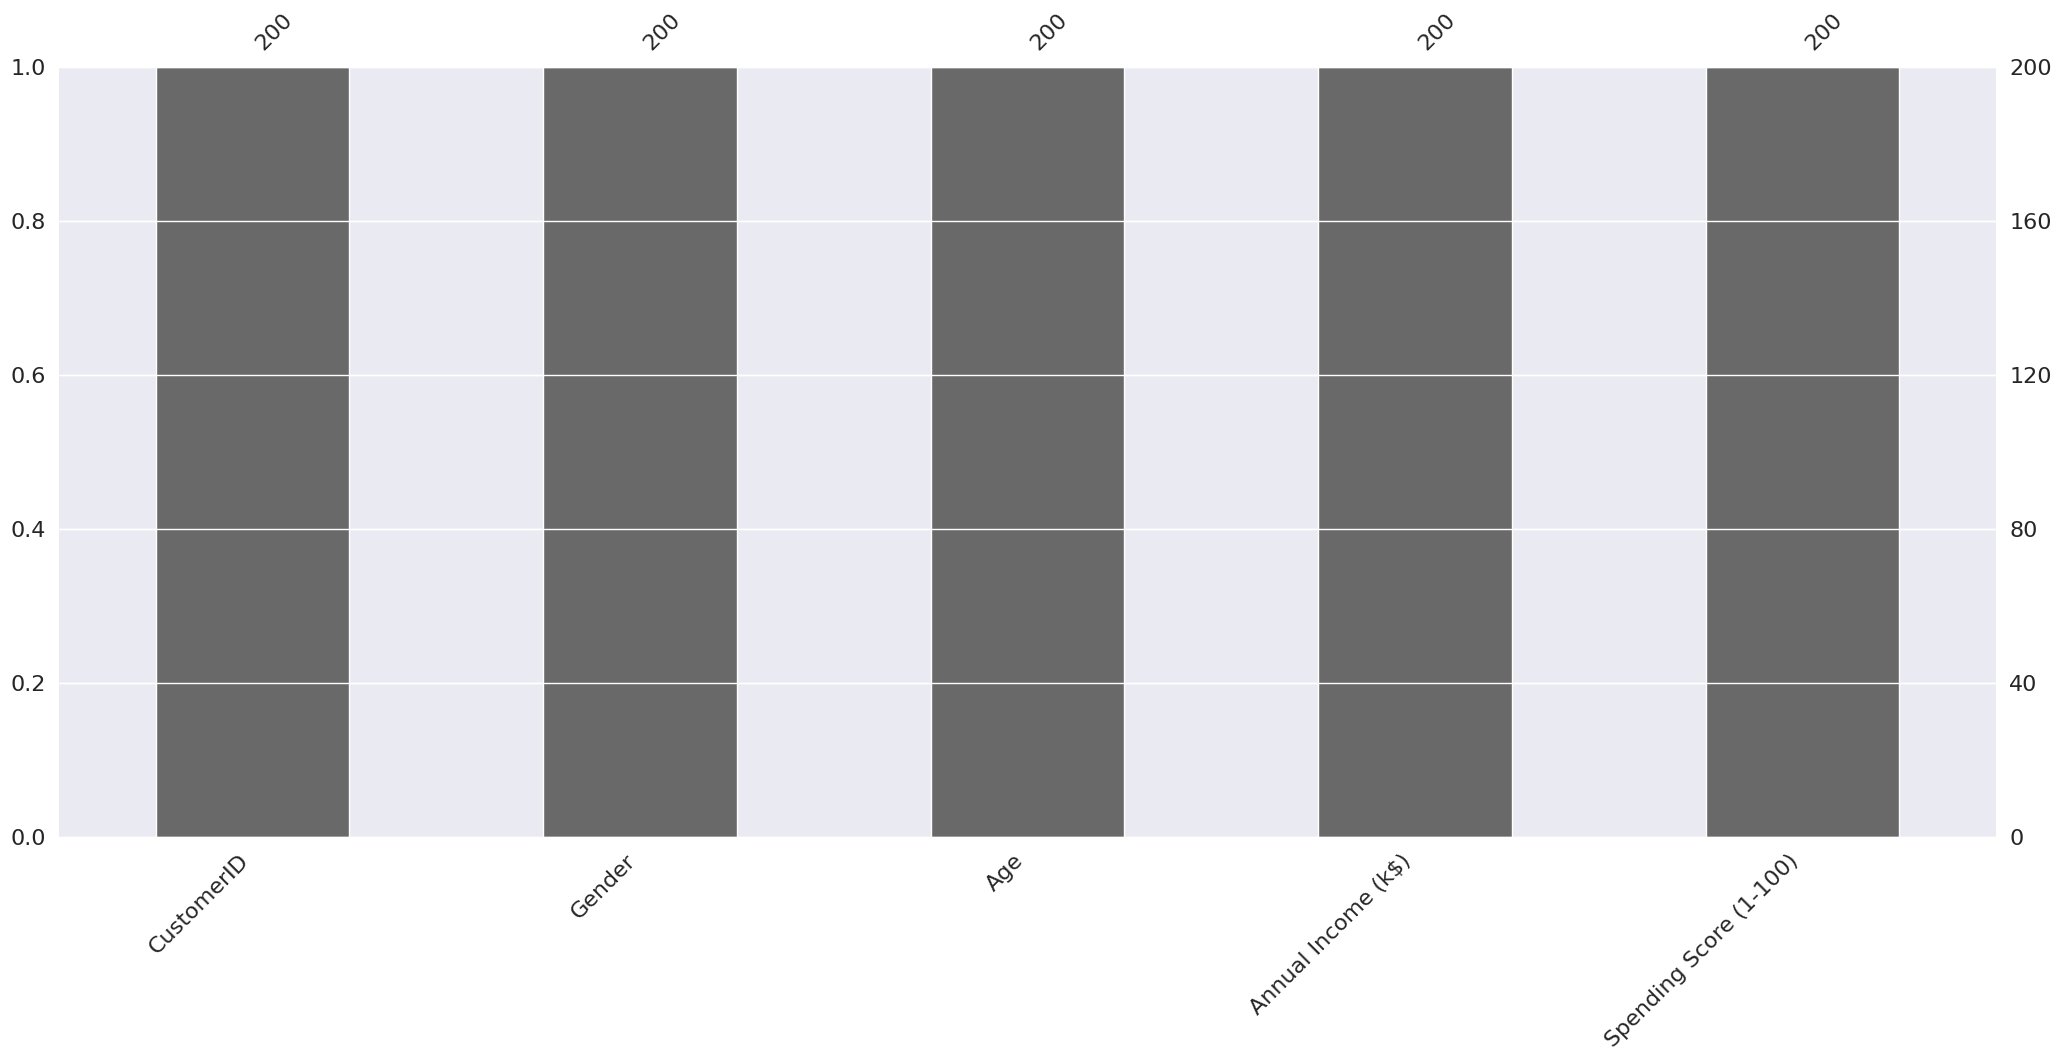

In [9]:
msn.bar(df)

We see that our dataset doesn't contain any missing values.

# 📊📈 Descriptive Analysis📊📈

### Boxplots and Outliers

Text(0.5, 1.0, 'Box plot of numerical columns')

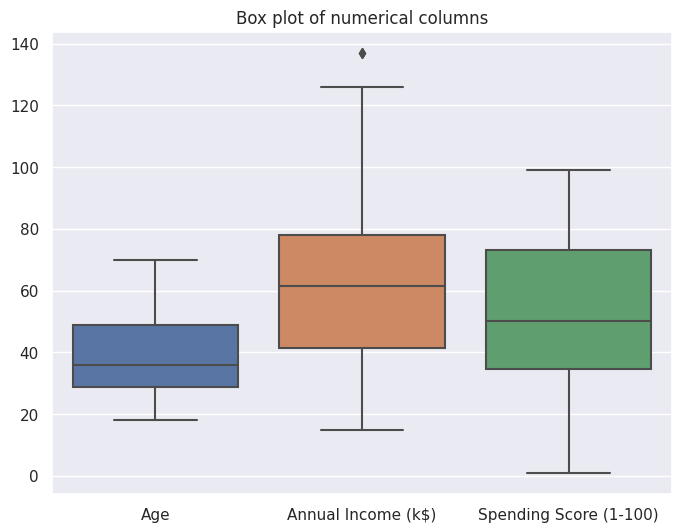

In [10]:
plt.figure(figsize=(8,6))
i=sns.boxplot(data[numerical_columns])
plt.title("Box plot of numerical columns")

> We notice that the different boxplots are well distributed.
> 
> We can easily distinguish the different quartiles of the different variables.. For instance, the variable Age, is a little bit assymetric (skewed to the right).
>
> The different variables have almost the same variance.

> Considering the fact that our variable have different dimensions, we will try to scale the Data.

>Finally, we notice that our dataset doesn't contain any outliers. 

In [11]:
df_scaled = df.copy()
df_scaled[numerical_columns]=(df_scaled[numerical_columns]-df_scaled[numerical_columns].mean())/df_scaled[numerical_columns].std()

Text(0.5, 1.0, 'Box plot of numerical columns')

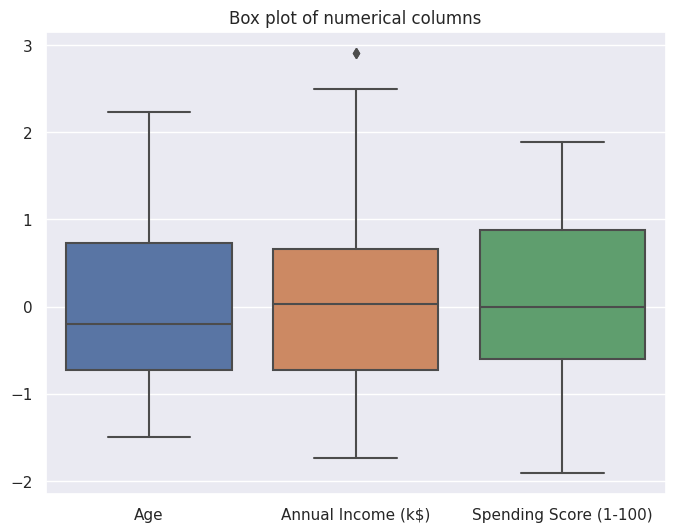

In [12]:
plt.figure(figsize=(8,6))
i=sns.boxplot(df_scaled[numerical_columns])
plt.title("Box plot of numerical columns")

We notice that the boxplots didn't change alot after scaling the data.

## 🔢📏 Quantitative Variables🔢📏

### Densities

I will estimate the density of the numerical columns using the kernel density estimation method.

In [16]:
def density(data,plot_variables,size,color,l,c,nmax=None):
    fig, axes = plt.subplots(l,c,figsize=size)
    if min(l,c)>1:
        for i in range(l):
            for j in range(0,c):
                sns.kdeplot(data[plot_variables[c*i+j]],ax=axes[i,j],color=color,fill=True)
                axes[i,j].set_title(f"Density plot of {plot_variables[c*i+j]}")
    elif min(l,c)==1:
        for i in range(len(plot_variables)):
            sns.kdeplot(data[plot_variables[i]],ax=axes[i],color=color,fill=True)
            axes[i].set_title(f"Density plot of {plot_variables[i]}")



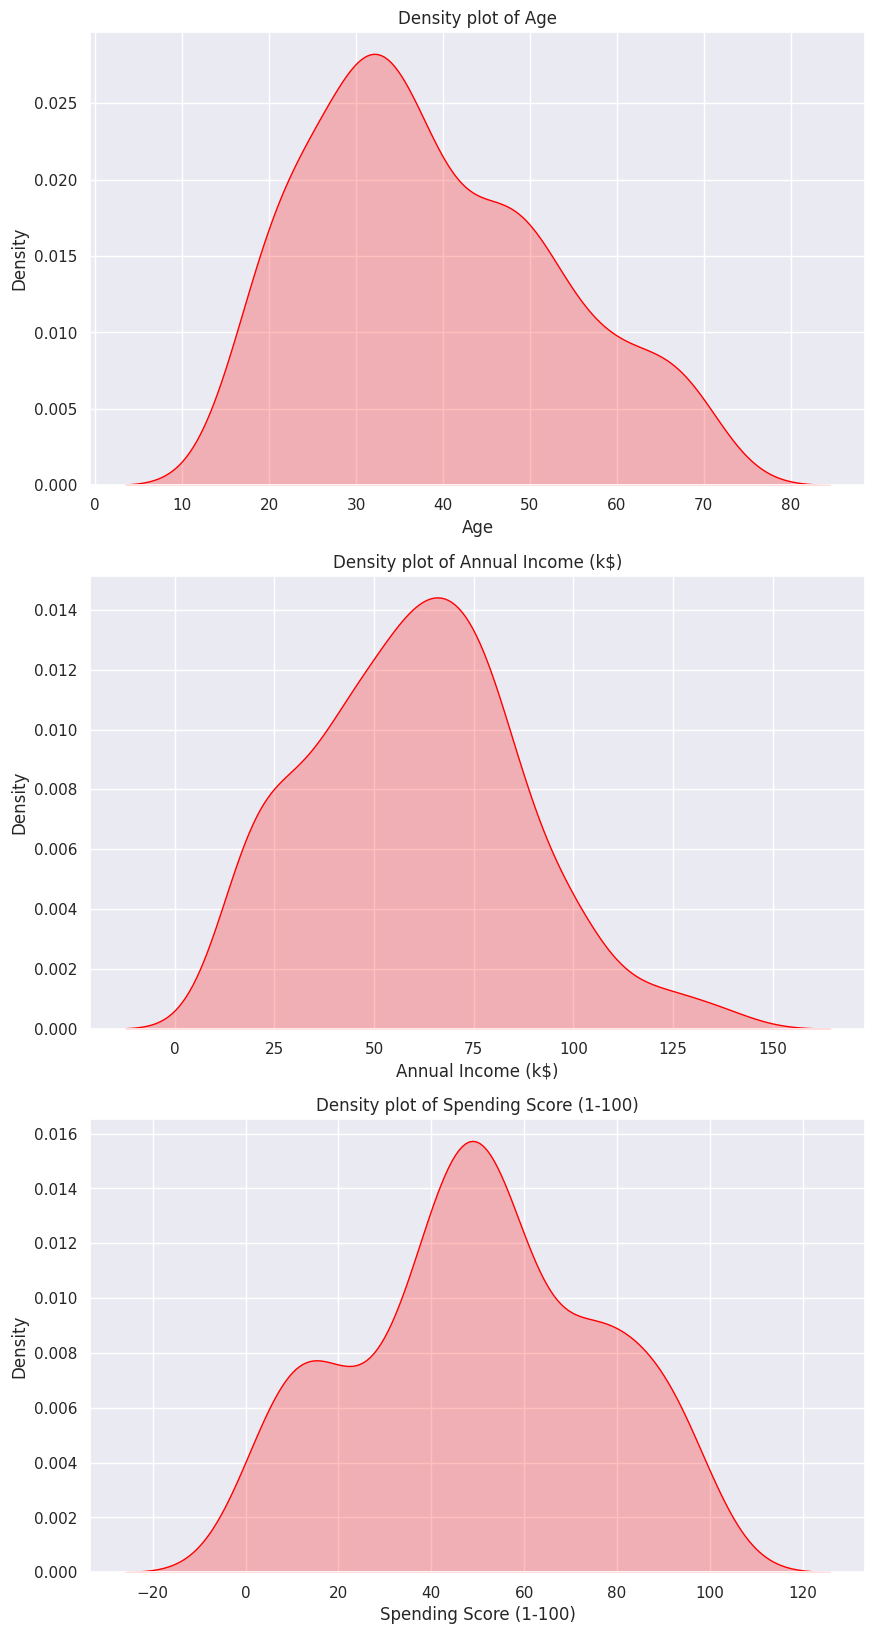

In [29]:
density(df,numerical_columns,(10,20),'red',3,1)

## 🔤Qualitative Variables🔤

Text(0.5, 1.0, 'Count plot of Pizza Brands')

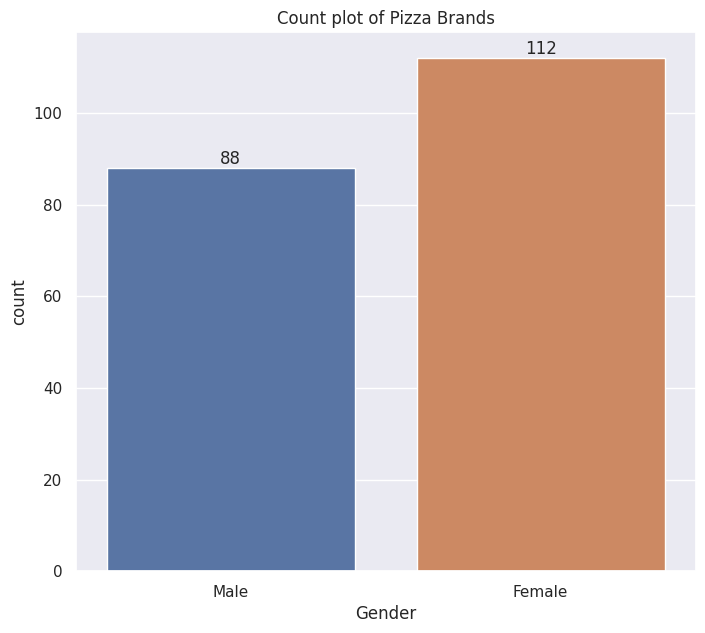

In [31]:
fig,ax=plt.subplots(1,1,figsize=(8,7))
sns.countplot(data=data,x='Gender',axes=ax)
ax.bar_label(ax.containers[0],label_type='edge')
ax.set_title("Count plot of Pizza Brands")

We can see that $112$ of the customers are Female and $88$ are Males

## 🔄📊Bi-Variate Analysis🔄📊

### Correlation Matrix

<Axes: >

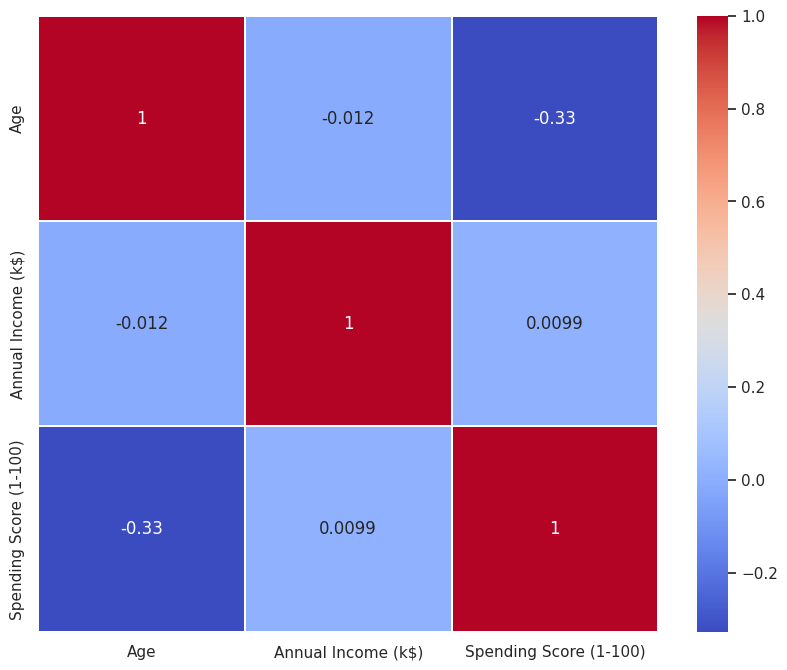

In [32]:
plt.figure(figsize=(10,8))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.2)

> We can notice that there is no strong correlation between the different variables. Indeed, it is expected that the variables are not correlated. For example, the Annual Income of a customer is not correlated to the Age. 

> However, the correlation matrix shows that there is no strong lineal relationship between the Spending Score and the Annual Income of the customers nor the Age of the customers.

### Pairplot

Text(0.5, 1.02, 'Pairplot of numerical columns colored by Gender')

<Figure size 1000x800 with 0 Axes>

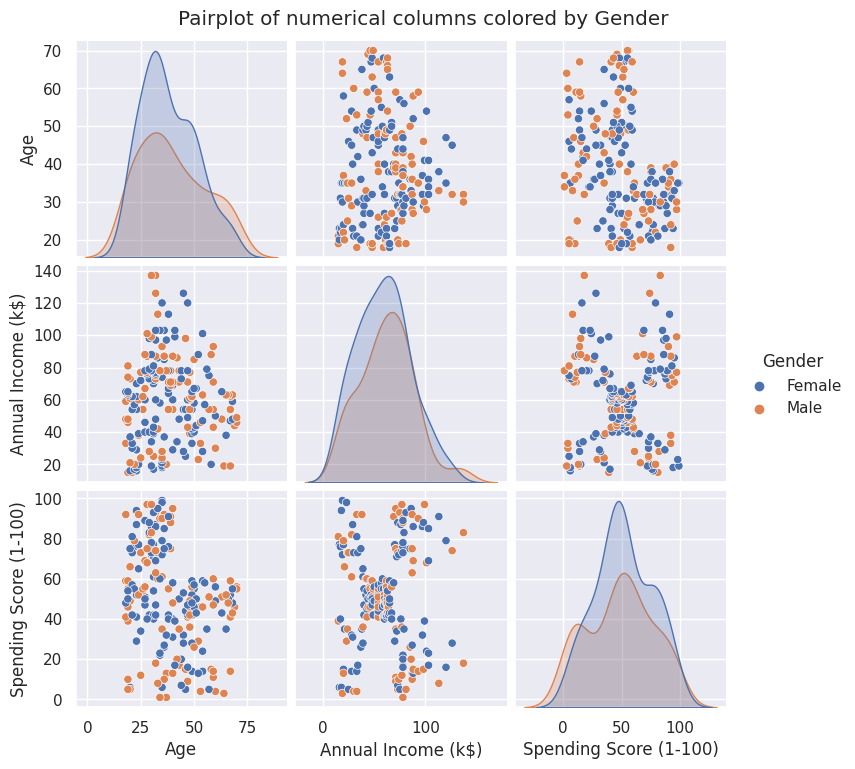

In [33]:
plt.figure(figsize=(10,8))
sns.pairplot(df,vars= numerical_columns,hue='Gender')
plt.suptitle("Pairplot of numerical columns colored by Gender", y=1.02)

# 📈Méthodes factorielles📈

In this part, I am going to perform Principal Coponent Analysis (PCA) in order to see if we can reduce the dimension of the data and if we can see some differences between the brands of pizzas.

## Principal Component Analysis

In [47]:
from sklearn.decomposition import PCA

In [48]:
pca = PCA()
pca.fit(df_scaled[numerical_columns])

PCA()

### Explained Variance

Text(0.5, 1.0, 'Cimulative Explained Variance')

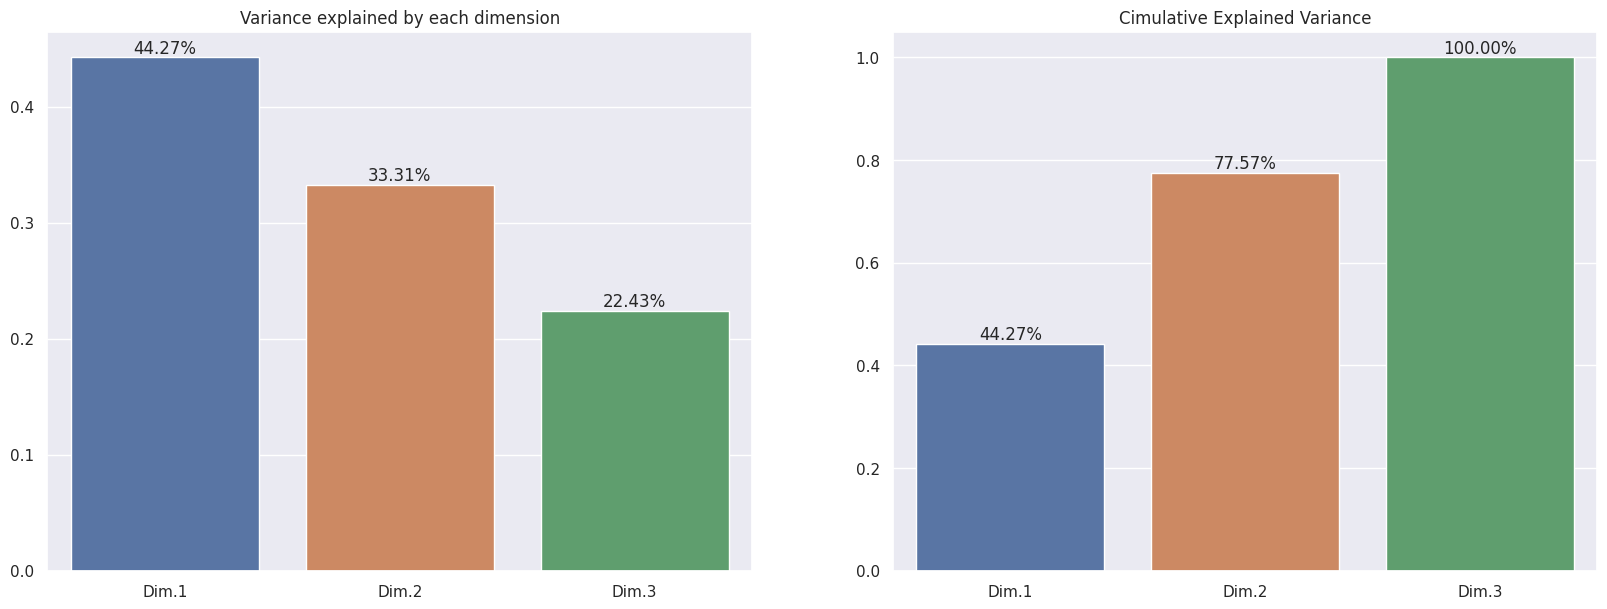

In [49]:
variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)




fig, ax = plt.subplots(1,2,figsize=(20,7))
sns.barplot(x=["Dim." + str(dim) for dim in np.arange(1, len(cumulative_variance) + 1)], y=variance,ax=ax[0])
ax[0].bar_label(ax[0].containers[0], labels=[f'{val:.2%}' for val in variance], label_type='edge')
ax[0].set_title("Variance explained by each dimension")


sns.barplot(x=["Dim." + str(dim) for dim in np.arange(1, len(cumulative_variance) + 1)], y=cumulative_variance,ax=ax[1])
ax[1].bar_label(ax[1].containers[0], labels=[f'{val:.2%}' for val in cumulative_variance], label_type='edge')
ax[1].set_title("Cimulative Explained Variance")


We can deduce that we must consider 4 PCA components are enough to explain 75% of the variance of the data and therefore 75% of the information.

### Individual Factor Map

In [50]:
def pca_plot_individuals(pca,data=df,pca_variables=numerical_columns,n_pca=df.shape[0],n_plot=df.shape[0],inverse=False,markers=False,edgecolor='black',dim1=1 , dim2=2,size=(10,8),to_c = True,c_column=None,is_categorical=False,is_numerical=False):
    if n_pca < n_plot:
        n_plot = n_pca

    if is_categorical:
        is_numerical=False
    else:
        is_numerical=True
    

    subset_df = data.sample(n_pca)

    if inverse:
        inverse= -1
    else:
        inverse = +1

    C= pca.transform(subset_df[pca_variables])
    C= pd.DataFrame(C,index=subset_df.index,columns=['Dim.' + str(dim) for dim in np.arange(1, len(pca_variables) + 1)])

    plt.figure(figsize=size)
    C_sample = C.sample(n_plot)
    names=C_sample.index
    if to_c and c_column : 
        c= subset_df.loc[C_sample.index,c_column]
    
    if is_categorical:
        scatter = sns.scatterplot(x=C_sample[C_sample.columns[dim1-1]],y=inverse*C_sample[C_sample.columns[dim2-1]],hue=c,edgecolor=edgecolor)
    elif is_numerical:
        scatter = plt.scatter(x=C_sample[C_sample.columns[dim1-1]],y=inverse*C_sample[C_sample.columns[dim2-1]],c=c,edgecolor=edgecolor)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    if markers:
        for x,y,nom in zip(C_sample.iloc[:,0],C_sample.iloc[:,1],names):
            plt.text(x,y,nom)
    if to_c and is_numerical :
        cbar=plt.colorbar(scatter)
        cbar.ax.set_title(c_column)
    plt.title(f"Individual plot of PCA in dimensions {dim1} and {dim2}")
    plt.xlabel(f"dim{dim1} with inertia {pca.explained_variance_ratio_[dim1-1]:.2%}")
    plt.ylabel(f"dim{dim2} with inertia {pca.explained_variance_ratio_[dim2-1]:.2%}")


    plt.show()
        

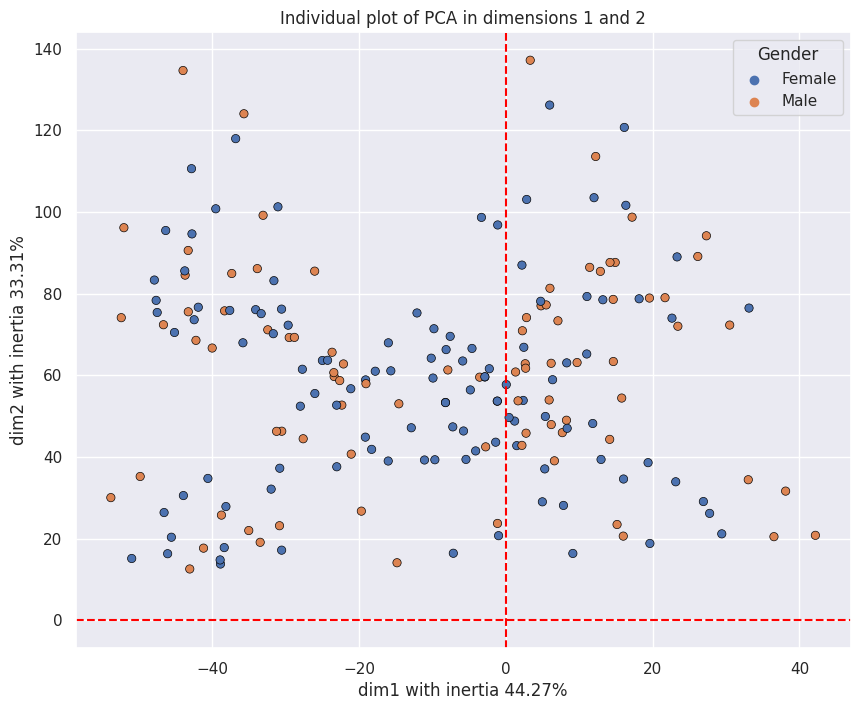

In [52]:
pca_plot_individuals(pca,to_c=True,markers=False,c_column='Gender',size=(10,8),is_categorical=True)

### Variable Factor Map

In [53]:
def plot_pca_varcor(pca,inverse=False,data=df[numerical_columns],Legend=True,markers=True,plot_variables = numerical_columns,dim1 = 1 , dim2=2,size=(12,12)):
    if inverse:
        inverse= -1
    else:
        inverse = +1
    

    conponents = pd.DataFrame(pca.components_,columns=data.columns,index=range(0,len(pca.components_)))
    conponents = conponents[plot_variables]
    coord1 = inverse*conponents.iloc[dim1-1,:] * np.sqrt(pca.explained_variance_[dim1-1])
    coord2 = inverse*conponents.iloc[dim2-1,:] * np.sqrt(pca.explained_variance_[dim2-1])
    couleurs = plt.cm.get_cmap('tab20',len(data.columns))
    fig=plt.figure(figsize=size)
    ax=fig.add_subplot(1,1,1)
    legend = []
    head_length=0.05
    for i,j,nom,couleur in zip(coord1,coord2,plot_variables,couleurs.colors):
        legend.append(nom)
        if i >0 and j >0 :
            angle = np.arctan(j/i)
        elif i<0 and j >0 :
            angle = np.pi + np.arctan(j/i)
        elif i>0 and j <0 :
            angle =  np.arctan(j/i)
        elif i<0 and j <0 :
            angle = np.arctan(j/i)
        else:
            angle = 0
        if markers:
            plt.text(i,j,nom,fontsize=15)
        
        plt.arrow(0,0,i-head_length * np.cos(angle),j-head_length * np.sin(angle),color=couleur,head_width=0.05,label=nom,head_length=0.05)

    plt.axis((-1.2,1.2,-1.2,1.2))
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    c=plt.Circle((0,0),radius=1,color='blue',fill=False)


    plt.xlabel(f"dim{dim1} with inertia {pca.explained_variance_ratio_[dim1-1]:.2%}")
    plt.ylabel(f"dim{dim2} with inertia {pca.explained_variance_ratio_[dim2-1]:.2%}")
    plt.title(f"Variable correlation in dimensions {dim1} and {dim2}")
    ax.add_patch(c)
    if Legend:
       plt.legend(plot_variables,loc='best')
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.show()



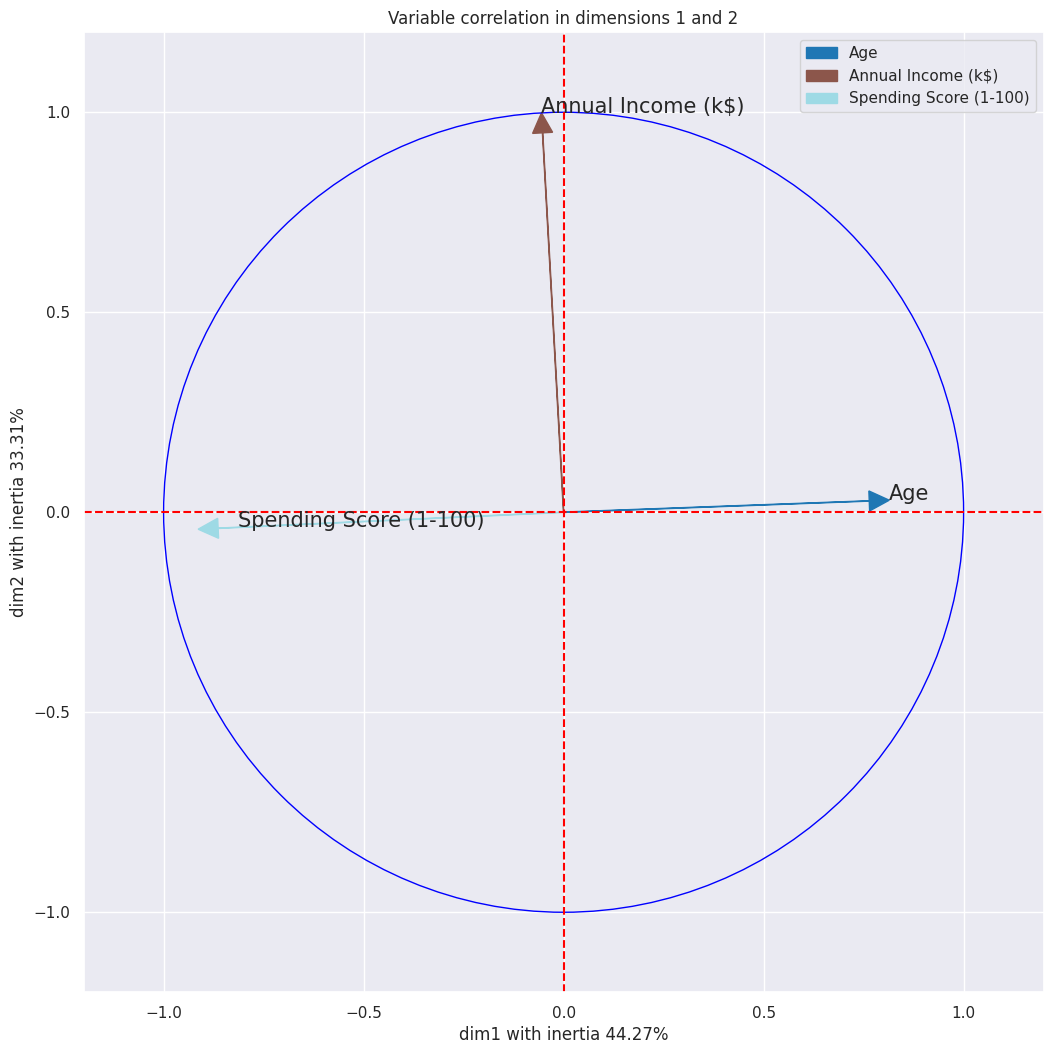

In [54]:
plot_pca_varcor(pca,markers=True,size=(12,12))

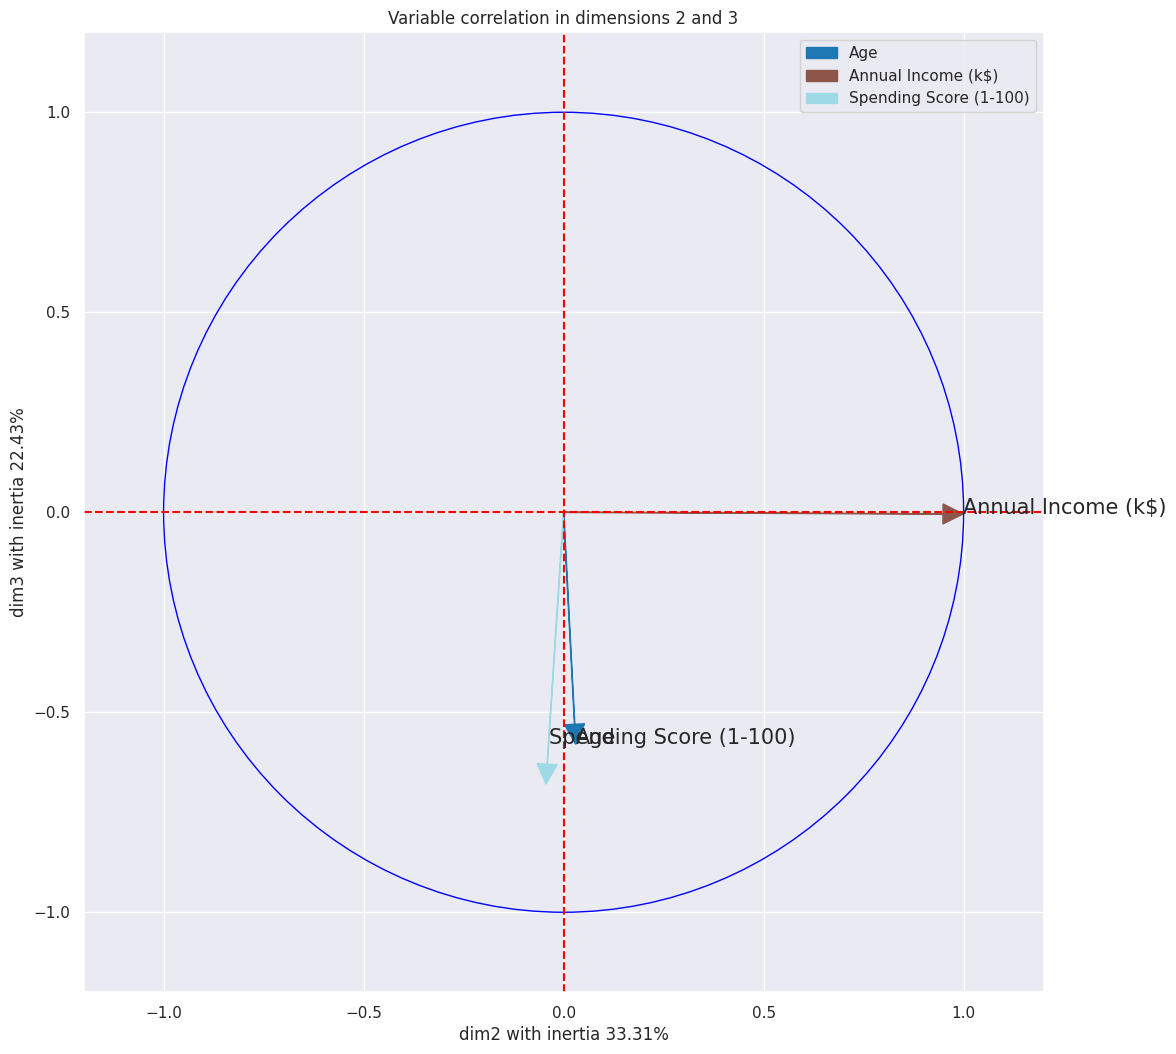

In [55]:
plot_pca_varcor(pca,markers=True,size=(12,12),dim1=2,dim2=3)

In orther to see if we can better separate the brands, we will perform a Linear Discriminant Analysis (LDA).